In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
import os
import cv2
import torch
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset

In [2]:
# local packages import
from Base_unit_dataset import HollowKnightActionDataset
from train_test_factory import build_train_val_datasets, TransformWrapper
from train import train_action_classifier

In [3]:
import matplotlib.pyplot as plt

def show_dataset_sample(dataset, idx):
    image, label = dataset[idx]

    image = image.permute(1, 2, 0).cpu().numpy()

    class_name = dataset.id_to_class[label]

    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f'Class: {class_name}')
    plt.axis('off')
    plt.show()

2096 407
[Dataset] Classes: ['hornet', 'hornet_drill', 'hornet_ram', 'hornet_silk', 'hornet_throw']
[Dataset] Total samples: 2095


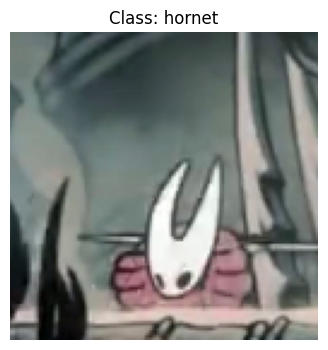

In [4]:
hornet_dataset = HollowKnightActionDataset(
    root_dir='../project/coco_dataset',
    annotation_file='annotations.xml',
    target_size=(128, 128)
)

train_ds, val_ds = build_train_val_datasets([hornet_dataset])



show_dataset_sample(train_ds, idx=750)

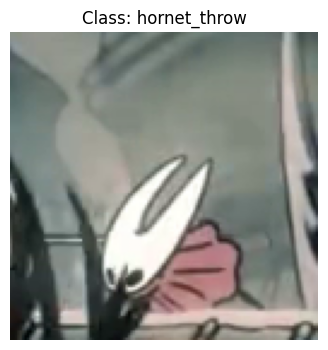

In [5]:
show_dataset_sample(train_ds, idx=15)

In [6]:
len(train_ds)

1676

In [7]:
train_ds[0][1]

0

In [8]:
# from collections import Counter
# # dataset = HollowKnightActionDataset(root_dir='dataset_root')
# print(Counter([y for _, y in dataset]))


In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1,  bias=False)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=1, bias=False)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.down_sample = nn.Identity()
        if in_channels != out_channels or stride != 1:
            self.down_sample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
                
            )

    def forward(self, x):
        identity = x
        if self.down_sample is not None:
            identity = self.down_sample(x)
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.relu(out)
        # 2 слой
        out = self.conv2(out)
        out = self.batch2(out)
        # должны быть одинаковые размеры
        out += identity
        out = self.relu(out)
        return out

In [10]:
class CustomLightNet(nn.Module):
    def __init__(self, num_clusses=21):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.LeakyReLU(inplace=True)
        self.basic1 = ResidualBlock(16, 16)
        self.basic2 = ResidualBlock(16, 16) 

        self.basic3 = ResidualBlock(16, 32, stride=2)
        self.basic4 = ResidualBlock(32, 32, stride=1) 

        self.basic5 = ResidualBlock(32, 64, stride=2)
        self.basic6 = ResidualBlock(64, 64, stride=1) 

        self.basic7 = ResidualBlock(64, 128, stride=2)
        self.basic8 = ResidualBlock(128, 128, stride=1) 

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        #  Dropout
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(128, num_clusses)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.relu((self.bn1((self.conv1((x))))))
        
        out = self.basic2(self.basic1(out))
        out = self.basic4(self.basic3(out))
        out = self.basic6(self.basic5(out))
        out = self.basic8(self.basic7(out))
        
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        
        out = self.dropout(out)
        
        out = self.fc(out)
        return out

In [11]:
import json


In [12]:
transform = A.Compose([
    # A.HorizontalFlip(p=0.5),
    # A.ColorJitter(brightness=0.2, contrast=0.2, p=0.3),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])



train_ds = TransformWrapper(train_ds, transform)
val_ds = TransformWrapper(val_ds, transform)

print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")


train_loader = DataLoader(
    train_ds, 
    batch_size=32, 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True 
)

val_loader = DataLoader(
    val_ds, 
    batch_size=32, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True 
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")
if device.type == 'cuda':
    print(f"Имя GPU: {torch.cuda.get_device_name(0)}")


model = CustomLightNet(num_clusses=5) 
model = model.to(device)

Train size: 1676, Val size: 419
Используется устройство: cuda
Имя GPU: NVIDIA GeForce RTX 3060


In [16]:
model_ResNet = model
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
optimizer_ResNet = torch.optim.AdamW(model_ResNet.parameters(), lr=0.001, weight_decay=1e-3)
epochs = 2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ResNet, 
    mode='max', 
    factor=0.5, 
    patience=5, 
    # verbose=True
)

In [18]:
trained_model_ResNet, history_ResNet, best_acc = train_action_classifier(
    model=model_ResNet,
    train_loader=train_loader, 
    val_loader=val_loader,    
    criterion=criterion,
    optimizer=optimizer_ResNet,
    scheduler=scheduler,
    epochs=epochs,
    device=device
)

Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:20<00:00,  2.62it/s, loss=0.978]


Epoch [1/2] Train Loss: 0.9774 | Train Acc: 0.7267 | Val Loss: 1.0033 | Val Acc: 0.7399 -> Best model saved (val_acc=0.7399)
--------------------------------------------------------------------------------


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:20<00:00,  2.59it/s, loss=0.684]


Epoch [2/2] Train Loss: 0.8641 | Train Acc: 0.7655 | Val Loss: 1.0445 | Val Acc: 0.6659 
--------------------------------------------------------------------------------


In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader

def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Обратное преобразование нормализации для отображения"""
    mean = np.array(mean)
    std = np.array(std)
    # Tensor (C, H, W) -> Numpy (H, W, C)
    img = tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

In [33]:
import torch
import random
import math
import matplotlib.pyplot as plt


def show_classified_crops(
    dataloader,
    model,
    class_names,
    device,
    # mean=(0.485, 0.456, 0.406),
    # std=(0.229, 0.224, 0.225),
    max_classes=25
):
    model.eval()

    num_classes = len(class_names)
    class_indices = list(range(num_classes))

    # если классов больше max_classes — берём случайные
    if num_classes > max_classes:
        class_indices = random.sample(class_indices, max_classes)

    class_indices = set(class_indices)

    samples = {}  # class_id -> (image, true_label, pred_label)

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            for img, gt, pred in zip(images, labels, preds):
                gt = gt.item()
                if gt in class_indices and gt not in samples:
                    samples[gt] = (
                        img.cpu(),
                        gt,
                        pred.cpu().item()
                    )

                if len(samples) == len(class_indices):
                    break
            if len(samples) == len(class_indices):
                break

    if not samples:
        print("No samples found for visualization")
        return

    # ---------- Plot ----------
    n = len(samples)
    cols = min(5, n)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten() if n > 1 else [axes]

    for ax in axes[n:]:
        ax.axis('off')

    for ax, (cls_id, (img, gt, pred)) in zip(axes, samples.items()):
        # img = denormalize(img, mean, std)

        gt_name = class_names[gt]
        pred_name = class_names[pred]

        color = 'green' if gt == pred else 'red'

        ax.imshow(img)
        ax.set_title(
            f"GT: {gt_name}\nPred: {pred_name}",
            fontsize=10,
            color=color
        )
        ax.axis('off')

        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    plt.tight_layout()
    plt.show()


TypeError: Invalid shape (3, 128, 128) for image data

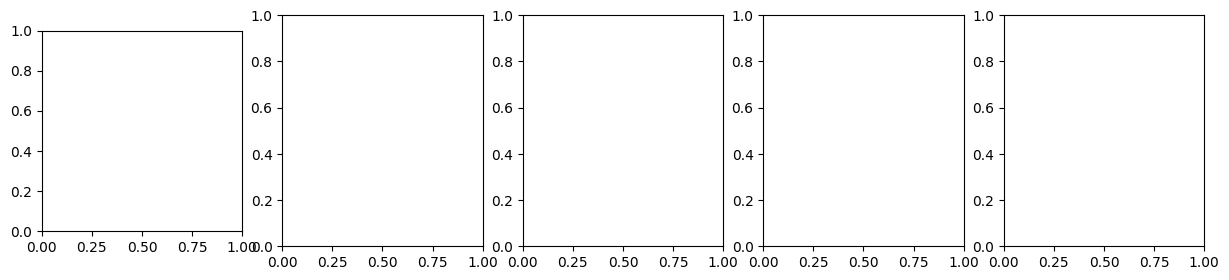

In [34]:
show_classified_crops(val_loader, trained_model_ResNet, val_ds.classes, "cuda")

In [29]:
def show_classified_crops(dataloader, model, class_names, device, count=5, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):

    model.eval()
    images, labels = next(iter(dataloader))
    with torch.no_grad():
        images_cuda = images.to(device) 
        outputs = model(images_cuda)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu() 
    
    n_images = min(count, len(images))
    fig, axes = plt.subplots(1, n_images, figsize=(15, 4))
    
    if n_images == 1: axes = [axes]
        
    for i in range(n_images):
        img = denormalize(images[i].cpu(), mean, std)
        
        true_idx = labels[i].item()
        pred_idx = preds[i].item()
        true_text = class_names[true_idx]
        pred_text = class_names[pred_idx]
        color = 'green' if true_idx == pred_idx else 'red'
        
        title = f"True: {true_text}\nPred: {pred_text}"
            
        axes[i].imshow(img)
        axes[i].set_title(title, fontsize=10, color=color)
        axes[i].axis('off')
        for spine in axes[i].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
    
    plt.tight_layout()
    plt.show()

In [30]:
def evaluate_model(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    print(f"Start evaluation on {len(loader.dataset)} samples...")

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n" + "="*50)
    print("Classification Report (Precision, Recall, F1-Score per class):")
    print("="*50)
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    print("="*50)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))

    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d',   
        cmap='Blues', 
        xticklabels=class_names, 
        yticklabels=class_names 
    )
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.show()

Примеры кропов из валидационной выборки с предсказаниями


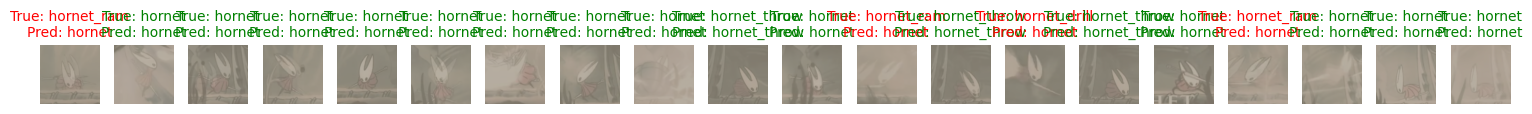

In [31]:
print("Примеры кропов из валидационной выборки с предсказаниями")
show_classified_crops(
    dataloader=val_loader, 
    model=trained_model_ResNet, 
    class_names=val_ds.classes, 
    device=device, 
    count=20 
)
#

In [32]:
print("Детальная статистика по классам")
evaluate_model(
    model=trained_model_ResNet, 
    loader=val_loader, 
    device=device, 
    class_names=class_names
)
#

Детальная статистика по классам


NameError: name 'class_names' is not defined